# Titanic Survival Prediction
This project analyses the Titanic dataset (obtained from [hbiostat.org](https://hbiostat.org/data/repo/titanic3.csv)) to predict survival using machine learning, with custom feature engineering to improve model performance. It builds upon the [Data Science in VS Code tutorial](https://code.visualstudio.com/docs/datascience/data-science-tutorial), extending it with additional features (`family_size`), statistical tests (chi-squared), and models (Logistic Regression, XGBoost).

In [155]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Add this to suppress TensorFlow INFO messages
np.random.seed(0) # Set random seeds for reproducibility 
tf.random.set_seed(0)
data = pd.read_csv('titanic3.csv')

# Data overview
print(f"Dataset shape: {data.shape}")
print("\nMissing values per column:")
print(data.isnull().sum())
print("\nFirst few rows:")
print(data.head())

Dataset shape: (1309, 14)

Missing values per column:
pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

First few rows:
   pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

     age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.00      0      0   24160  211.3375       B5        S    2    NaN   
1   0.92      1      2  113781  151

### Dataset Overview
The Titanic dataset contains 1309 rows and 14 columns, with missing values in `age`, `fare`, and other columns. The `survived` column is the target variable, with 0 indicating non-survival and 1 indicating survival.

To clean the data, we replace cells containing '?' with the numpy NaN value, which Python is able to interpret for purposes of graphing. Then, we update the data types of the `age` and `fare` columns:

In [156]:
data.replace('?', np.nan, inplace = True)
data = data.astype({"age": np.float64, "fare": np.float64})

Next, we use seaborn and matplotlib to create two violin plots and three point plots, illustrating some basic relationships between variables:

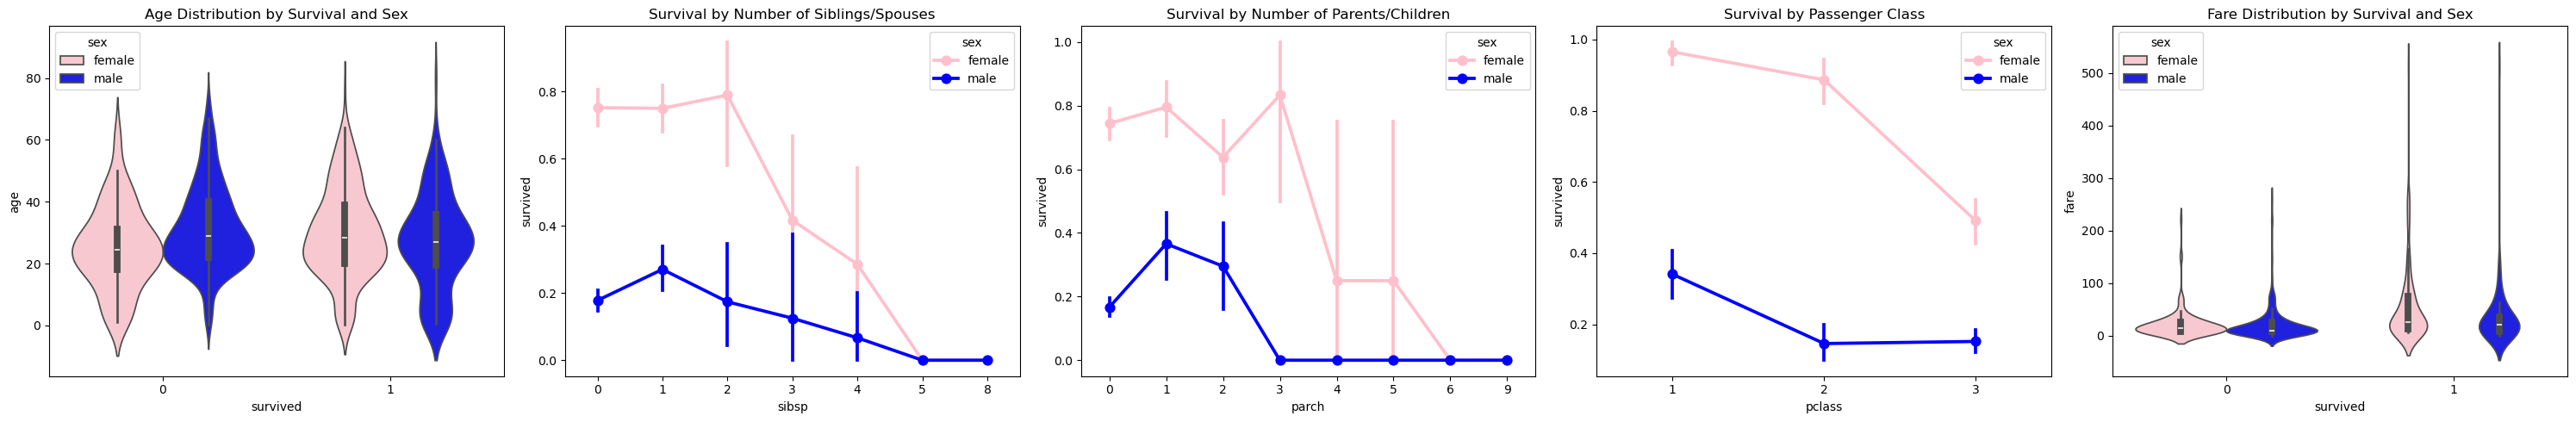

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom colour palette
palette = {'female': 'pink', 'male': 'blue'}

fig, axs = plt.subplots(ncols = 5, figsize = (30, 5))
sns.violinplot(x = "survived", y = "age", hue = 'sex', data = data, ax = axs[0], palette = palette)
axs[0].set_title('Age Distribution by Survival and Sex')
sns.pointplot(x = "sibsp", y = "survived", hue = 'sex', data = data, ax = axs[1], palette = palette)
axs[1].set_title('Survival by Number of Siblings/Spouses')
sns.pointplot(x = "parch", y = "survived", hue = 'sex', data = data, ax = axs[2], palette = palette)
axs[2].set_title('Survival by Number of Parents/Children')
sns.pointplot(x = "pclass", y = "survived", hue = 'sex', data = data, ax = axs[3], palette = palette)
axs[3].set_title('Survival by Passenger Class')
sns.violinplot(x = "survived", y = "fare", hue = 'sex', data = data, ax = axs[4], palette = palette)
axs[4].set_title('Fare Distribution by Survival and Sex')
plt.tight_layout()
plt.show()

### Insights from Violin and Point Plots
- **Age vs. Survival**: Females who survived have a broader age range (20-40), while males who survived are slightly younger. Non-survivors are concentrated around 20-30 years.
- **SibSp vs. Survival**: Females have higher survival rates (~0.8) with `sibsp` = 1-2, while males’ survival drops sharply to ~0.0 for `sibsp` ≥ 3.
- **Parch vs. Survival**: Females with `parch` = 1-3 have high survival rates (~0.8); males’ survival peaks at `parch` = 1-2 (~0.3) but falls to ~0.0 for `parch` ≥ 4.
- **Pclass vs. Survival**: Survival decreases from `pclass` = 1 to 3. Females in `pclass` = 1 have a ~0.9 survival rate, while males in `pclass` = 3 have a ~0.1 rate, confirming the predictive power of `pclass`.
- **Fare vs. Survival**: Survivors paid higher fares on average, with females who survived paying up to 500. Non-survivors mostly paid less than 100, indicating wealth influenced survival.

In order to compute correlations using pandas, all variable types involved in the calculations must be numeric. Since `sex` is currently stored as a string, we can replace their values with a binary pair of integers:

In [158]:
pd.set_option('future.no_silent_downcasting', True)  # Opt into future behavior to suppress warning
data.replace({'male': 1, 'female': 0}, inplace = True)

We are now ready to compute the correlation between survival and the other variables, which will be helpful in determining good inputs for a machine learning model:

In [159]:
data.corr(numeric_only=True).abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
age,0.055512
sibsp,0.027825
parch,0.082660
fare,0.244265
body,NaN


Here we see that `sex` has a relatively high correlation with survival, while other variables like `sibsp` (number of siblings/spouse on board) or `parch` (number of parents/children on board) appear to have little correlation.

### Family Features
To explore more deeply the impact of family dynamics on survival rates, we will engineer the following features:
- `relatives`: a binary measure of whether or not the passenger has at least one parent, child, sibling, or spouse on board (1 if at least one, 0 if none);
- `family_size`: a total count of the number of relatives a passenger has on board.

After adding these variables to the data, we recompute the correlations:

In [160]:
data['relatives'] = data.apply (lambda row: int((row['sibsp'] + row['parch']) > 0), axis=1)
data['family_size'] = data['sibsp'] + data['parch']
data.corr(numeric_only=True).abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
age,0.055512
sibsp,0.027825
parch,0.082660
fare,0.244265
body,NaN
relatives,0.201719
family_size,0.026876


The `relatives` feature correlates more with survival than `family_size`, which has low correlation.

### Statistical Analysis
A chi-squared test will check if `survived` and `sex` are independent, building on their high correlation:

In [161]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(data['survived'], data['sex'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared statistic: {chi2:.4f}, p-value: {p:.4f}")

Chi-squared statistic: 363.6179, p-value: 0.0000


A p-value of less than 0.0001 indicates a statistically significant relationship between `survived` and `sex`.

A heatmap visualises correlations between numeric features to identify strong predictors:

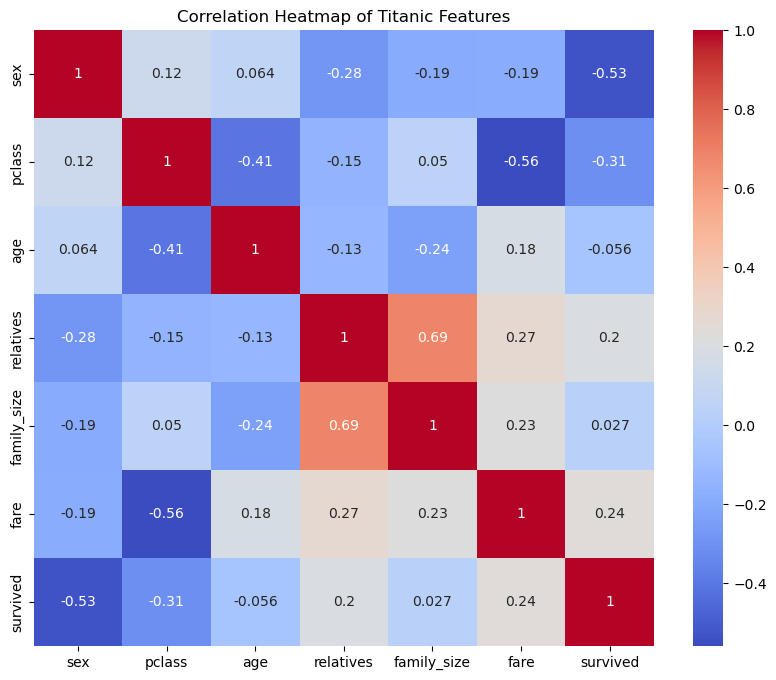

In [162]:
plt.figure(figsize = (10, 8))
sns.heatmap(data[['sex', 'pclass', 'age', 'relatives', 'family_size', 'fare', 'survived']].corr(), 
            annot = True, cmap = 'coolwarm')
plt.title('Correlation Heatmap of Titanic Features')
plt.show()

The heatmap confirms `sex` and `pclass` as the strongest correlates with `survived`, while `family_size` has a weaker relation.

## Creating a Machine Learning Model
With the dataset prepared, we train and evaluate machine learning models using sklearn to predict `survived`, involving preprocessing, training, and accuracy evaluation.

We split the dataset into training and validation sets, excluding `NaN` values and low-correlation variables like `sibsp` and `parch`. Most models include `family_size`, but we first test Naive Bayes without it for comparison.

In [163]:
from sklearn.model_selection import train_test_split

# Split data with family_size (used by most models)
data = data[['sex', 'pclass', 'age', 'relatives', 'family_size', 'fare', 'survived']].dropna()
x_train_fs, x_test_fs, y_train_fs, y_test_fs = train_test_split(
    data[['sex', 'pclass', 'age', 'relatives', 'family_size', 'fare']], 
    data.survived,test_size = 0.2, random_state = 0)

Next, we standardise the inputs using `StandardScaler`. The shared features (`sex`, `pclass`, `age`, `relatives`, `fare`) are scaled consistently across all models, while `family_size` is scaled separately to ensure proper preprocessing:

In [164]:
from sklearn.preprocessing import StandardScaler

# Define a single StandardScaler for shared features
sc = StandardScaler()
shared_features = ['sex', 'pclass', 'age', 'relatives', 'fare']
X_train_shared = sc.fit_transform(x_train_fs[shared_features])
X_test_shared = sc.transform(x_test_fs[shared_features])

# For the dataset without family_size (used only by Naive Bayes for comparison)
X_train_no_fs = X_train_shared
X_test_no_fs = X_test_shared
y_train_no_fs = y_train_fs  # Same split, just different features
y_test_no_fs = y_test_fs

The next step is to select a machine learning algorithm to model the data. For now, we will use the Naive Bayes algorithm:

In [165]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train_no_fs, y_train_no_fs)

GaussianNB()

Now that the model is trained, we can test it against the validation data. Upon making its predictions, we can then calculate the accuracy of the model:

In [166]:
from sklearn import metrics

predict_test_no_fs = model.predict(X_test_no_fs)
nb_accuracy_without = metrics.accuracy_score(y_test_no_fs, predict_test_no_fs)
print(f"Naive Bayes (without family_size): {nb_accuracy_without:.4f}")

Naive Bayes (without family_size): 0.7464


Thus, the trained algorithm has a 74.64% success rate when estimating survival.

Now, we compare the performance of the Naive Bayes model when we include the `family_size` feature in the dataset:

In [167]:
import numpy as np

# Handle family_size separately
sc_family_size = StandardScaler()
X_train_family_size = sc_family_size.fit_transform(x_train_fs[['family_size']])
X_test_family_size = sc_family_size.transform(x_test_fs[['family_size']])

# Combine scaled features for the dataset with family_size
X_train_fs = np.hstack([X_train_shared, X_train_family_size])
X_test_fs = np.hstack([X_test_shared, X_test_family_size])

model = GaussianNB()
model.fit(X_train_fs, y_train_fs)
predict_test_fs = model.predict(X_test_fs)
nb_accuracy_with = metrics.accuracy_score(y_test_fs, predict_test_fs)
print(f"Naive Bayes (with family_size): {nb_accuracy_with:.4f}")

Naive Bayes (with family_size): 0.7560


Addition of the `family_size` feature to the dataset slightly improves performance of the Naive Bayes model to 75.60%.

## Using a Neural Network
Using Keras and TensorFlow, we can create a neural network to test against the Titanic dataset, and compare its performance with the machine learning models. In this case we will use a Sequential neural network:

In [168]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

Next, we need to add the layers of the neural network. Note that the dimension of the first layer must equal the number of inputs, while output of the last layer must be one-dimensional (i.e., whether a passenger survived or not). To start with, we will exclude `family_size`:

In [169]:
model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 5))
model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))

Here is a summary of the model thus constructed:

In [170]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_43 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 6         
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


Next, the model has to be compiled:

In [171]:
model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train_no_fs, y_train_no_fs, batch_size = 16, epochs = 100, shuffle = False);

Epoch 1/100
53/53 [==============================] - 3s 10ms/step - loss: 0.6927 - accuracy: 0.5644
Epoch 2/100
53/53 [==============================] - 1s 14ms/step - loss: 0.6889 - accuracy: 0.5644
Epoch 3/100
53/53 [==============================] - 1s 13ms/step - loss: 0.6728 - accuracy: 0.6298
Epoch 4/100
53/53 [==============================] - 0s 7ms/step - loss: 0.6340 - accuracy: 0.7602
Epoch 5/100
53/53 [==============================] - 0s 7ms/step - loss: 0.5818 - accuracy: 0.7673
Epoch 6/100
53/53 [==============================] - 1s 13ms/step - loss: 0.5387 - accuracy: 0.7740
Epoch 7/100
53/53 [==============================] - 1s 13ms/step - loss: 0.5139 - accuracy: 0.7719
Epoch 8/100
53/53 [==============================] - 1s 14ms/step - loss: 0.5013 - accuracy: 0.7757
Epoch 9/100
53/53 [==============================] - 1s 10ms/step - loss: 0.4946 - accuracy: 0.7710
Epoch 10/100
53/53 [==============================] - 0s 8ms/step - loss: 0.4900 - accuracy: 0.7649
Ep

Once built and trained, the model can be tested against the validation data:

In [172]:
y_pred_no_fs = np.rint(model.predict(X_test_no_fs).flatten())
nn_accuracy_without = metrics.accuracy_score(y_test_no_fs, y_pred_no_fs)
print(f"Neural network (without family_size): {nn_accuracy_without:.4f}")

Neural network (without family_size): 0.7943


The accuracy of this neural network in estimating survival is 79.43%, outperforming the Naive Bayes Classifier.

We can compare this result to a model trained with the dataset including the `family_size` feature:

In [173]:
model = Sequential()
model.add(Dense(6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 6))
model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))
model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train_fs, y_train_fs, batch_size = 16, epochs = 100, shuffle = False);
y_pred_fs = np.rint(model.predict(X_test_fs).flatten())
nn_accuracy_with = metrics.accuracy_score(y_test_fs, y_pred_fs)
print(f"Neural network (with family_size): {nn_accuracy_with:.4f}")

Epoch 1/100
53/53 [==============================] - 2s 5ms/step - loss: 0.6926 - accuracy: 0.5570
Epoch 2/100
53/53 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.5880
Epoch 3/100
53/53 [==============================] - 0s 5ms/step - loss: 0.6726 - accuracy: 0.7463
Epoch 4/100
53/53 [==============================] - 0s 6ms/step - loss: 0.6387 - accuracy: 0.7656
Epoch 5/100
53/53 [==============================] - 0s 6ms/step - loss: 0.5934 - accuracy: 0.7781
Epoch 6/100
53/53 [==============================] - 0s 6ms/step - loss: 0.5525 - accuracy: 0.7740
Epoch 7/100
53/53 [==============================] - 1s 12ms/step - loss: 0.5235 - accuracy: 0.7668
Epoch 8/100
53/53 [==============================] - 0s 7ms/step - loss: 0.5059 - accuracy: 0.7716
Epoch 9/100
53/53 [==============================] - 0s 5ms/step - loss: 0.4961 - accuracy: 0.7784
Epoch 10/100
53/53 [==============================] - 0s 4ms/step - loss: 0.4907 - accuracy: 0.7798
Epoch 11

Adding the `family_size` feature slightly improves the accuracy to 79.90%.

### Model Comparison: Logistic Regression and XGBoost
To further compare model performance, we evaluate two additional algorithms: Logistic Regression (a linear model) and XGBoost (a tree-based ensemble method), using the same features as the Naive Bayes and Neural Network models with `family_size`:

In [174]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train_fs, y_train_fs)
lr_accuracy = metrics.accuracy_score(y_test_fs, lr_model.predict(X_test_fs))

# XGBoost
xgb_model = XGBClassifier(eval_metric = 'logloss')
xgb_model.fit(X_train_fs, y_train_fs)
xgb_accuracy = metrics.accuracy_score(y_test_fs, xgb_model.predict(X_test_fs))

print(f"Logistic regression (with family_size): {lr_accuracy:.4f}")
print(f"XGBoost (with family_size): {xgb_accuracy:.4f}")

Logistic regression (with family_size): 0.7847
XGBoost (with family_size): 0.8134


### Model Comparison Results
The table below summarises the test accuracies of all models (all include `family_size`):

| Model            | Accuracy |
|------------------|----------|
| Naive Bayes      | 0.7560   |
| Neural Network   | 0.7990   |
| Logistic Regression | 0.7847   |
| XGBoost          | 0.8134   |

XGBoost slightly outperforms Naive Bayes, Logistic Regression, and the Neural Network, likely due to its ability to capture non-linear relationships more effectively.

## Conclusion
This project predicts Titanic survival using machine learning (Naive Bayes, Neural Network, Logistic Regression, XGBoost), achieving up to 81.34% accuracy with XGBoost, the best-performing model. Feature engineering (`relatives`, `family_size`), statistical analysis (chi-squared test, p < 0.0001 for `sex` vs. `survived`), and visualisations (heatmap, violin plots) uncovered key predictors like `sex` and `pclass`. The project showcases data wrangling, statistical testing, modelling, and communication skills, with potential for further enhancements like a `title` feature.